### Library imports

In [1]:
# core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join as pjoin
%matplotlib inline

pd.options.display.max_colwidth = 200
pd.options.display.max_rows = 500

In [2]:
# ML-specific
from sklearn.model_selection import TimeSeriesSplit, StratifiedKFold

### Load data

In [3]:
data_path = pjoin('..', 'data')
df_train = pd.read_csv(pjoin(data_path, 'train_eng.csv'), engine='c')
df_test = pd.read_csv(pjoin(data_path, 'test_eng.csv'), engine='c')

# ignore_index from previous savings
df_train = df_train[df_train.columns[1:]]
df_test = df_test[df_test.columns[1:]]

In [4]:
# prepare grouped data
df_train.set_index('unique_id', inplace=True)
df_train = df_train[[c for c in df_train.columns if c in df_test.columns]]

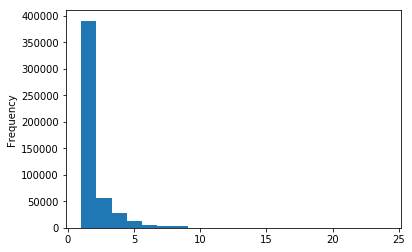

In [5]:
df_train_grouped = df_train.groupby(df_train.index).head(1).sort_index()
df_train_grouped['counts'] = df_train.groupby(df_train.index).size().sort_index()
df_train_grouped['counts'].plot(kind='hist', bins=20)
# add it to train also
df_train['counts'] = df_train_grouped['counts']

### Explore train dataset

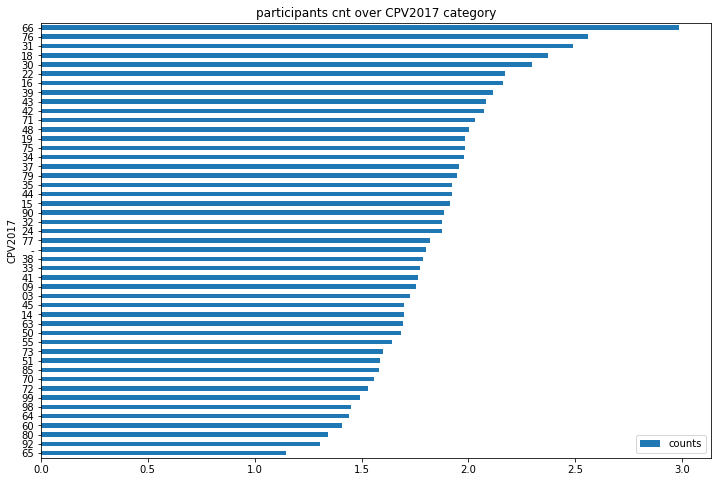

In [6]:
# numerical columns
df_train_grouped.groupby(df_train_grouped.CPV2017.fillna('0000').str[:2])\
.agg({'counts': 'mean'})\
.sort_values(by='counts')\
.plot(
    kind='barh',
    figsize=(12,8),
    title='participants cnt over CPV2017 category'
)
pass

In [7]:
# check tender statuses
df_train_grouped.groupby(df_train_grouped.TenderStatus).agg(
    {'counts':'mean', 'TenderStatus':'count'}).sort_values(by='counts', ascending=False)

TenderStatus    counts
TenderStatus                                                
active.pre-qualification                        18  3.222222
active.pre-qualification.stand-still             5  2.800000
complete                                    301492  2.261805
active.qualification                          1464  2.006831
active.awarded                                9112  1.956651
cancelled                                    32550  1.864977
unsuccessful                                155343  1.175727
active.tendering                                53  1.000000

In [8]:
# how many lots does organizer have
print('median: {:.2f}'.format(df_train_grouped.Organizer.value_counts().median()))
print('mean  : {:.2f}'.format(df_train_grouped.Organizer.value_counts().mean()))

median: 6.00
mean  : 28.55


In [9]:
# clean some garbage from delivery regions (heuristics)
true_regions = set(
    df_train_grouped[
        df_train_grouped.DeliveryRegion != '-'
    ].DeliveryRegion.str.strip().str[:6].value_counts()[:26].index.tolist()
                      )

df_train_grouped.loc[
    ~df_train_grouped.DeliveryRegion.str.strip().str[:6].isin(true_regions), 
    'DeliveryRegion'
] = 'Other'

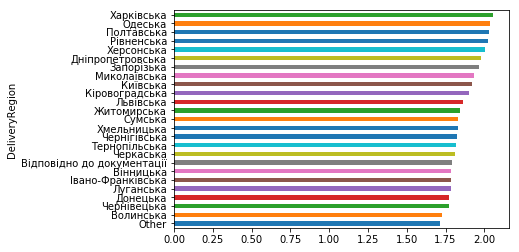

In [10]:
# participants cnt by delivery region
df_train_grouped.groupby(df_train_grouped.DeliveryRegion.fillna('NA'))\
.agg({'counts':'mean', 'DeliveryRegion':'count'})\
.sort_values(by=['DeliveryRegion', 'counts'], ascending=[False, False])\
.head(25)\
.sort_values(by='counts').counts.plot(kind='barh')

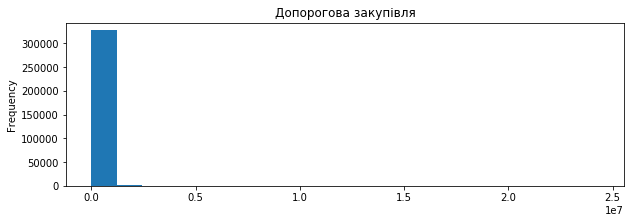

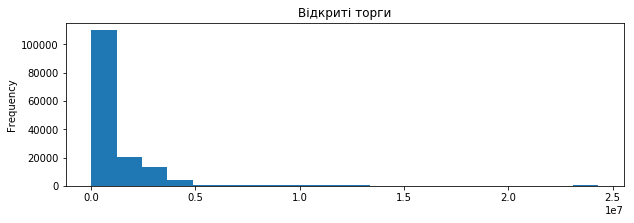

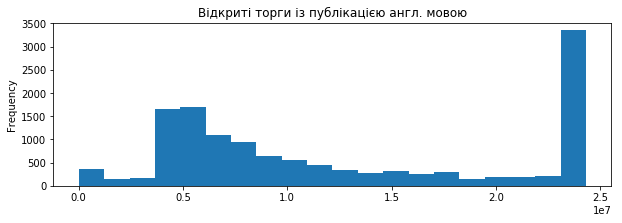

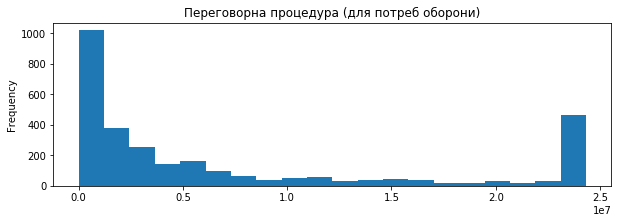

In [22]:
# tender amt distribution by TypeMethod
for tm in df_train_grouped.TypeMethod.unique():
    plt.figure(figsize=(10,3))
    df_train_grouped[df_train_grouped.TypeMethod == tm].SumTender.astype(np.float32)\
    .clip(
        lower=df_train_grouped.SumTender.astype(np.float32).quantile(0.005), 
        upper=df_train_grouped.SumTender.astype(np.float32).quantile(0.99)
    ).plot(kind='hist', bins=20, title=tm)

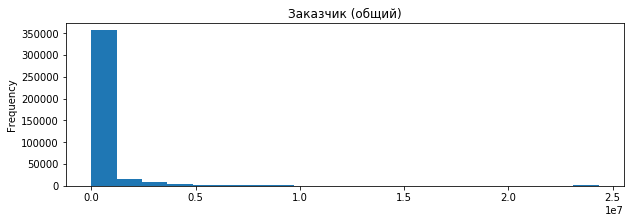

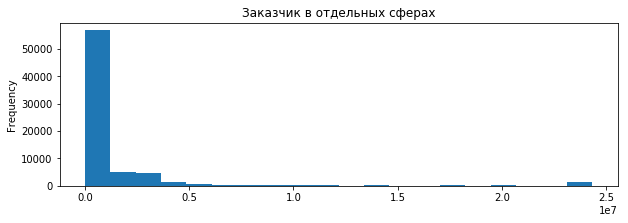

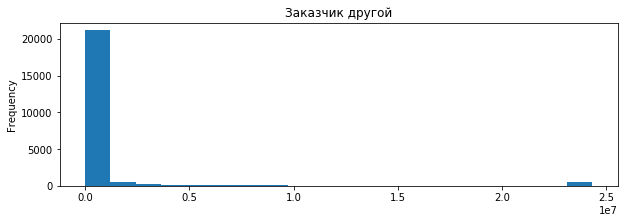

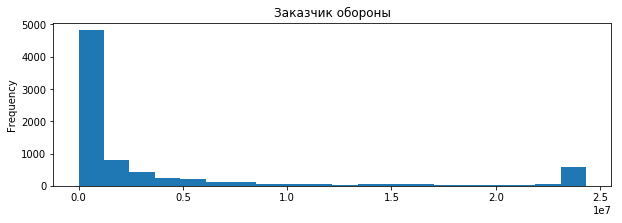

In [24]:
# tender amt distribution by TypeOrginizer
for tm in df_train_grouped.TypeOrginizer.unique():
    plt.figure(figsize=(10,3))
    df_train_grouped[df_train_grouped.TypeOrginizer == tm].SumTender.astype(np.float32)\
    .clip(
        lower=df_train_grouped.SumTender.astype(np.float32).quantile(0.005), 
        upper=df_train_grouped.SumTender.astype(np.float32).quantile(0.99)
    ).plot(kind='hist', bins=20, title=tm)

In [21]:
# vectorized error calc
def rmsle(y, y0):
    assert len(y) == len(y0)
    return np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y0), 2)))